# ARIMA Model for TimeSeries Forecasting 

# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import os
import pickle
%matplotlib inline

# Data Preproccessing

In [2]:
df = pd.read_csv('DataSets /WORLD-OWID-Features-Yearly')

In [3]:
df['year'] = pd.to_datetime(df['year'], format="%Y-%m-%d")

In [4]:
df.set_index('year', inplace=True)

In [5]:
df = df['co2']

In [6]:
#start_year = pd.to_datetime('1880-01-01')

#df = df.loc[start_year:]

df.head(10)

year
1880-01-01     853.705
1881-01-01     882.405
1882-01-01     931.922
1883-01-01     991.032
1884-01-01    1002.174
1885-01-01    1009.671
1886-01-01    1025.475
1887-01-01    1076.758
1888-01-01    1192.272
1889-01-01    1191.800
Name: co2, dtype: float64

# Data Visualization (Rolling mean & Standard Deviation )

**Rolling mean :** 

The window size represents the number of data points considered for the calculation. As the window moves through the time series, the moving average provides a smoother representation of the data, reducing noise and highlighting trends. 

Example: with a time series [1, 2, 3, 4, 5] and a window size of 3, the rolling mean for each point would be: [(1+2+3)/3, (2+3+4)/3, (3+4+5)/3] = [2, 3, 4] 

**Standard Deviation :** 

Similar as the Rolling mean but in stead of calculating the mean, ST calculates the ST of the datapoints within the sepcified window

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

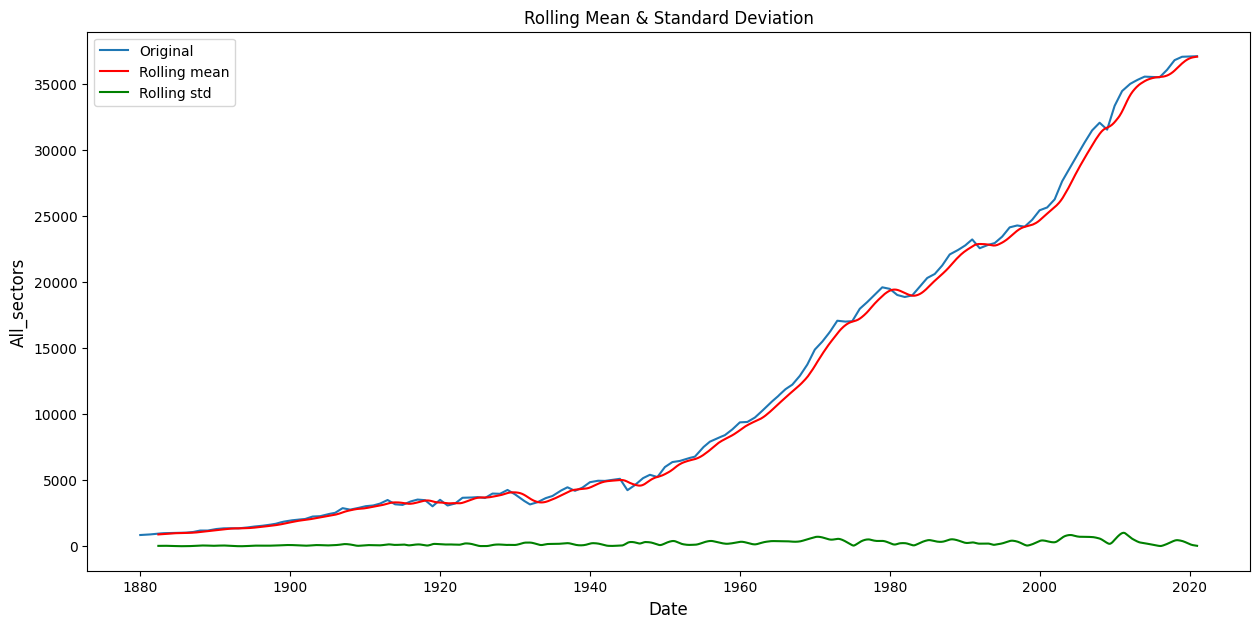

In [7]:
plt.figure(figsize=(15,7))
plt.plot(df, label='Original')
plt.plot(df.rolling(window=30).mean(), color='red', label='Rolling mean')  
plt.plot(df.rolling(window=30).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('All_sectors', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Both rolling mean and rolling standard deviation are useful tools for time series analysis, as they help to remove short-term fluctuations, make underlying trends more apparent, and provide valuable insights into the behavior of the data over time. They are commonly used in order to understand patterns in data and make predictions based on historical data.

# Testing if our Data is stationary or not 

The Augmented Dickey-Fuller Test is used to determine if the time-series data is stationary. I.e. if there is a trend or seasonality in the data 

When the result of the p-value is below 0.05 it is very likely that our data is stationary. 

We can also "verify" this using visualization and the "Test Statistic" metric. Usually if this metric is lower then our Citical values, this indicates stationary data and otherwise. 

In [8]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                    2.026834
p-value                           0.998707
Lags Used                        25.000000
Number of Observations Used    1667.000000
Critical Value (1%)              -3.434279
Critical Value (5%)              -2.863275
Critical Value (10%)             -2.567694
dtype: float64


# Decomposing into Trend and Seasonality

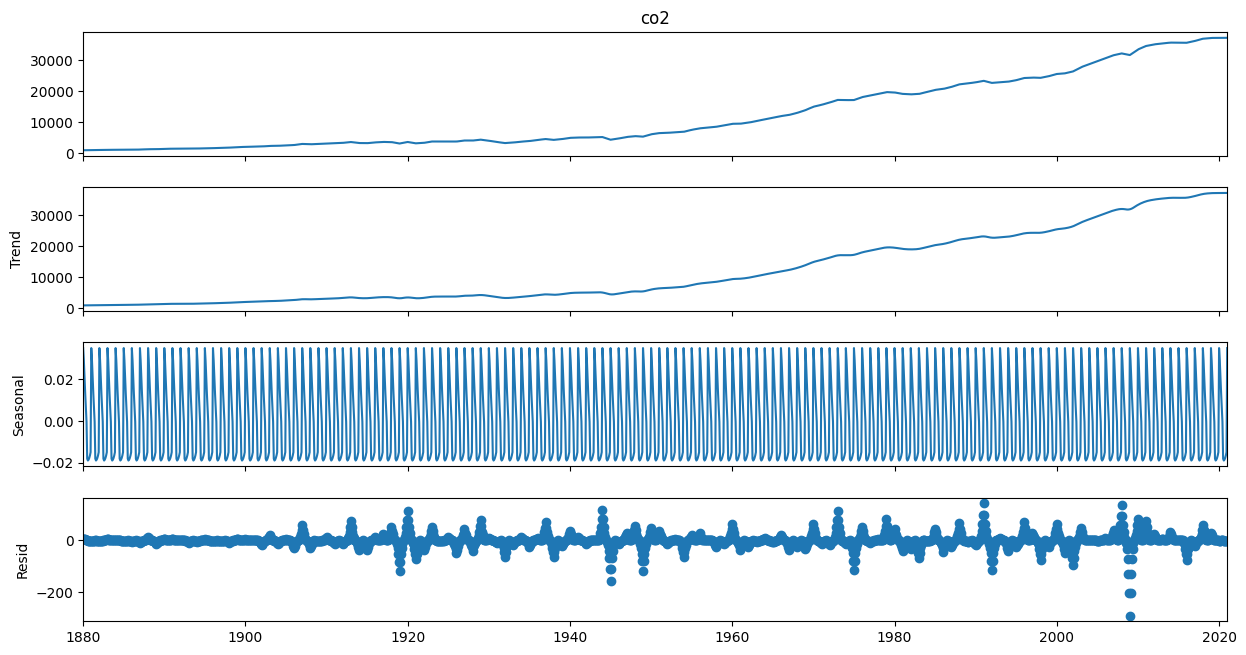

In [9]:
def seasonal_decompose(df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df)

# Selecting Train and Test sets 

In [7]:
train_size = int(len(df)*0.9) 
test_size = len(df) - train_size

In [8]:
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Finding the optimal value for Differencing (only if data is not stationary already)

If a time series has a trend or pattern that keeps changing over time, it's not stationary. To make it stationary, we take the difference between each data point and the previous one. If it's still not stationary, we repeat this step until it becomes stationary, and the number of times we do this is called "d." Stationary data is helpful for better predictions and analysis.

There are 2 main ways to do this: 
- By plotting the differencing orders
- By using AutoCorrelation

Text(0.5, 1.0, 'Autocorrelation for third-order differencing')

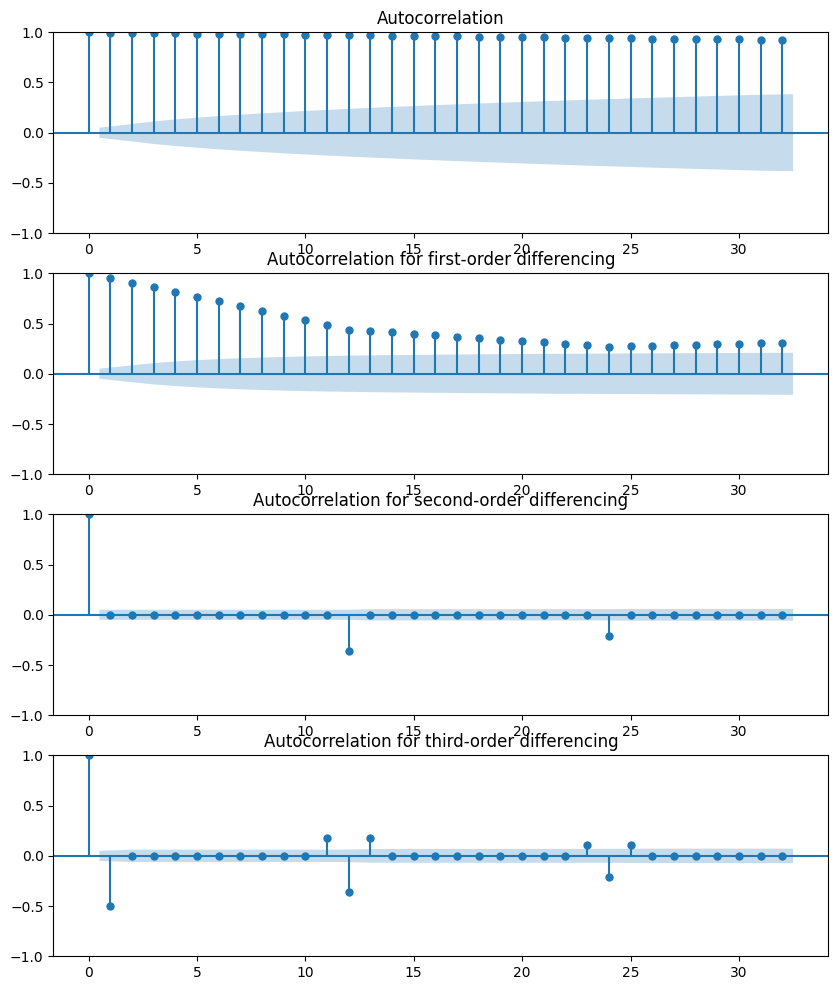

In [78]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
_ = plot_acf(train_data, ax=ax1)
_ = plot_acf(train_data.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')
_ = plot_acf(train_data.diff().diff().diff().dropna(), ax=ax4)
ax4.set_title('Autocorrelation for third-order differencing')

# Finding the optimal value for P (Autoregressive) parameter 

Trough finding the optimal P value, we can determine the number of autoregressive terms/repeats of a trend in the model. 
This will help us identify underlying correlations between the time-series and its legs. 

A correct choice of P ensures that the model effectively captures the underlying relationships and provides better forecasting performance.

Once again, this only need to be done when the data is not stationary. When the data is in fact stationary, the autocorrelations tend to dcay quickly. 

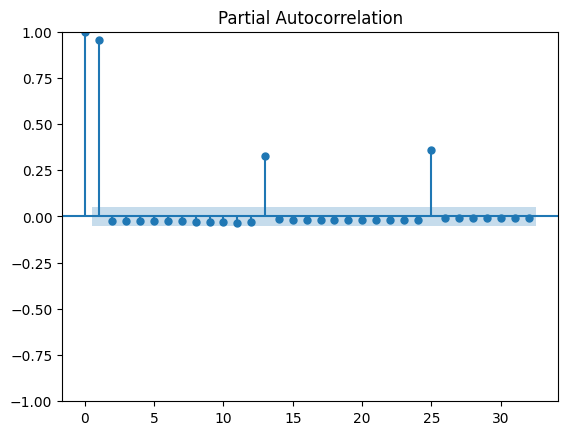

In [13]:
_ = plot_pacf(train_data.diff().dropna())

To get a better understanding of the PACF and ACF, you could enhance yourself by reading the following article: https://towardsdatascience.com/a-step-by-step-guide-to-calculating-autocorrelation-and-partial-autocorrelation-8c4342b784e8 

# Metric Function 

In [9]:
def print_metrics(pred, y_test, model_name):
    mae_ = mean_absolute_error(pred, y_test)
    rmse_ = np.sqrt(mean_squared_error(pred, y_test))
    mape_ = mean_absolute_percentage_error(pred, y_test)
    r2_score_ = r2_score(pred, y_test)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'R2': r2_score_
    }

    metrics = pd.DataFrame(dict_, index=[model_name])

    return metrics.round(decimals=2)

# Finding optimal parameters by using the auto_arima 

In [58]:
ARIMA_model = pm.auto_arima(train_data, m=32)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1523
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -5520.679
Date:                Fri, 18 Aug 2023   AIC                          11043.357
Time:                        01:05:36   BIC                          11048.684
Sample:                    01-01-1880   HQIC                         11045.340
                         - 11-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        83.2147      0.592    140.675      0.000      82.055      84.374
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            158732.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Implementing the ARIMA Model

In [59]:
best_order = ARIMA_model.order
best_seasonal_order = ARIMA_model.seasonal_order

best_ARIMA_model = pm.ARIMA(order=best_order, seasonal_order=best_seasonal_order)
ARIMA_model = best_ARIMA_model.fit(train_data)
ARIMA_model.summary()

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1523
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -5520.657
Date:                Fri, 18 Aug 2023   AIC                          11045.314
Time:                        01:05:51   BIC                          11055.968
Sample:                    01-01-1880   HQIC                         11049.280
                         - 11-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0485      0.234      0.207      0.836      -0.410       0.507
sigma2        83.2102      0.592    140.533      0.000      82.050      84.371
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            158732.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
model = ARIMA(df, order=(1, 2, 1))
arima_model = model.fit()
arima_model.summary()

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  142
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1019.533
Date:                Sun, 27 Aug 2023   AIC                           2045.065
Time:                        15:51:00   BIC                           2053.890
Sample:                    01-01-1880   HQIC                          2048.651
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1993      0.065      3.060      0.002       0.072       0.327
ma.L1         -0.9234      0.031    -29.874      0.000      -0.984      -0.863
sigma2      1.227e+05    1.1e+04     11.146      0.000    1.01e+05    1.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                51.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.65   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Sarimax model 

In [115]:
order = (32, 1, 1)
seasonal_order = (2, 1, 2, 34) 

model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
Sarimax_model = model.fit()
Sarimax_model.summary()

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56661D+00    |proj g|=  1.72114D-01


 This problem is unconstrained.



At iterate    5    f=  3.49592D+00    |proj g|=  4.30677D-02

At iterate   10    f=  3.45290D+00    |proj g|=  6.40853D-02

At iterate   15    f=  3.44177D+00    |proj g|=  1.93044D-02

At iterate   20    f=  3.44132D+00    |proj g|=  2.71255D-03

At iterate   25    f=  3.44109D+00    |proj g|=  1.10893D-02

At iterate   30    f=  3.44035D+00    |proj g|=  2.49313D-03

At iterate   35    f=  3.44029D+00    |proj g|=  4.99570D-04

At iterate   40    f=  3.44029D+00    |proj g|=  2.84765D-04

At iterate   45    f=  3.44029D+00    |proj g|=  4.76907D-04


/Users/wout_vp/venv-metal/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.44022D+00    |proj g|=  4.32054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     55      1     0     0   4.321D-03   3.440D+00
  F =   3.4402196939857634     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:                                      co2   No. Observations:                 1523
Model:             SARIMAX(32, 1, 1)x(2, 1, [1, 2], 34)   Log Likelihood               -5239.455
Date:                                  Fri, 18 Aug 2023   AIC                          10554.909
Time:                                          02:19:56   BIC                          10756.506
Sample:                                      01-01-1880   HQIC                         10630.042
                                           - 11-01-2006                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5253      8.047      0.065      0.948     -15.247      16.298
ar.L2          0.4698      7.932      0.059      0.953     -15.076      16.016
ar.L3         -0.0053      0.382     -0.014      0.989      -0.754       0.744
ar.L4         -0.0030      0.196     -0.015      0.988      -0.388       0.382
ar.L5          0.0011      0.372      0.003      0.998      -0.727       0.730
ar.L6          0.0029      0.200      0.015      0.988      -0.389       0.395
ar.L7          0.0051      0.350      0.015      0.988      -0.680       0.690
ar.L8         -0.0003      0.196     -0.001      0.999      -0.384       0.384
ar.L9         -0.0031      0.344     -0.009      0.993      -0.678       0.671
ar.L10         0.0011      0.190      0.006      0.995      -0.371       0.374
ar.L11        -0.0073      0.326     -0.022      0.982      -0.645       0.631
ar.L12        -0.4981      0.172     -2.891      0.004      -0.836      -0.160
ar.L13         0.2627      3.991      0.066      0.948      -7.560       8.085
ar.L14         0.2342      3.977      0.059      0.953      -7.561       8.030
ar.L15        -0.0053      0.384     -0.014      0.989      -0.758       0.747
ar.L16        -0.0055      0.202     -0.027      0.978      -0.402       0.391
ar.L17         0.0019      0.379      0.005      0.996      -0.741       0.745
ar.L18         0.0018      0.210      0.008      0.993      -0.409       0.413
ar.L19         0.0041      0.348      0.012      0.991      -0.678       0.686
ar.L20        -0.0017      0.203     -0.008      0.993      -0.400       0.396
ar.L21        -0.0019      0.314     -0.006      0.995      -0.618       0.614
ar.L22         0.0093      0.175      0.053      0.958      -0.334       0.353
ar.L23        -0.0070      0.322     -0.022      0.983      -0.639       0.625
ar.L24        -0.3895      0.182     -2.146      0.032      -0.745      -0.034
ar.L25         0.2009      3.108      0.065      0.948      -5.891       6.293
ar.L26         0.1893      3.061      0.062      0.951      -5.810       6.189
ar.L27        -0.0062      0.360     -0.017      0.986      -0.712       0.700
ar.L28        -0.0046      0.201     -0.023      0.982      -0.399       0.390
ar.L29        -0.0001      0.342     -0.000      1.000      -0.670       0.670
ar.L30         0.0009      0.193      0.004      0.996      -0.378       0.380
ar.L31        -0.0031      0.234     -0.013      0.990      -0.461       0.455
ar.L32        -0.0101      0.147     -0.069      0.945      -0.297       0.277
ma.L1          0.4665      8.044      0.058      0.954     -15.299      16.232
ar.S.L34      -0.7432      0.520     -1.428      0.153      -1.763       0.277
ar.S.L68       0.0378      0.079      0.478      0.633      -0.117       0.193
ma.S.L34      -0.2081      0.530     -0.393      0.694      -1.247       0.83

# Saving Models 

In [145]:
folder_path = "Saved_ARIMA_Models"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [196]:
model_file_path = os.path.join(folder_path, "other_industry_co2_ARIMA_Model.pkl")
with open(model_file_path, "wb") as f:
    pickle.dump(arima_model, f)

# Accessing Models 

In [137]:
selected_model_path = os.path.join(folder_path, 'Sarimax_model_373_0.93.pkl')

In [138]:
with open(selected_model_path, "rb") as f:
    loaded_model = pickle.load(f)

# Forecasting using the ARIMA & SARIMAX models

In [34]:
#ARIMA_model = ARIMA_model.fit(train_data)

In [71]:
pred = ARIMA_model.predict(len(test_data))

In [11]:
forecast = arima_model.forecast(len(test_data))

In [139]:
sarimax = loaded_model.forecast(len(test_data))

In [13]:
#metrics_df = print_metrics(pred, test_data, "ARIMA Model using AUTO_ARIMA")
metrics_df_2 = print_metrics(forecast, test_data, "ARIMA model using forecast")
#metrics_df_3 = print_metrics(sarimax, test_data, "SARIMAX model using forecast")

#concatenated_df = pd.concat([metrics_df, metrics_df_2, metrics_df_3])

print(metrics_df_2)

                                MAE     RMSE  MAPE    R2
ARIMA model using forecast  5398.35  5431.58  0.13 -8.21


Text(0, 0.5, 'co2')

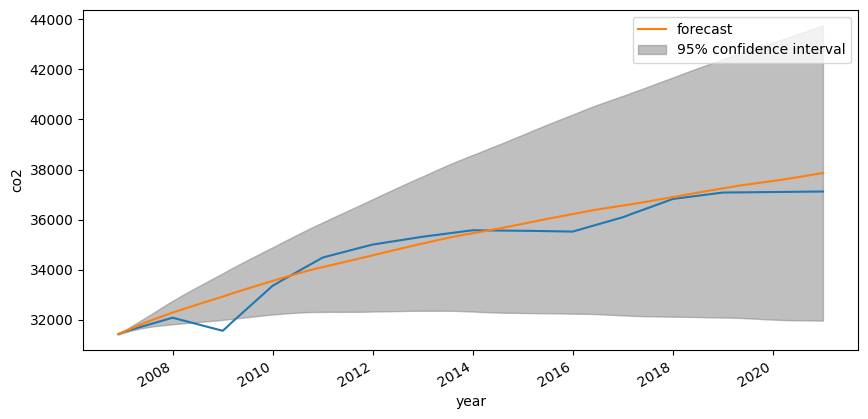

In [141]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(test_data)  ## df 
plot_predict(Sarimax_model, start=len(train_data), end=(len(df)-1), ax=axs)
plt.xlabel('year')
plt.ylabel('co2')